In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from glob import glob
import astropy.units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 28
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['axes.linewidth'] = 1

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
mappings_dir = './data/emission_line_ratios/'
mappings_name = 'M_n1_b*_s_lines.txt'
n_range = ['0_01', '0.1', '1', '10', '100', '1000']
solar_range = ['T', 'U', 'M', 'V', 'L', 'S']
init, n = 'M', '1'
metal = 'T'

In [5]:
def check_required_cols(df):
    # List of required columns
    required_columns = ['Atom', 'Species', 'Wavelength', '100.','125.', '150.', '175.', '200.', '225.',
       '250.', '275.', '300.', '325.', '350.', '375.', '400.', '425.', '450.',
       '475.', '500.', '525.', '550.', '575.', '600.', '625.', '650.', '675.',
       '700.', '725.', '750.', '775.', '800.', '825.', '850.', '875.', '900.',
       '925.', '950.', '975.', '1000.']
    # Check for missing columns and add them with None values
    df = df.reindex(columns=required_columns, fill_value=None)
    return df


In [11]:
def plot_O32_O3Hb_grid(metal, label='solar', type='s', savefig=True, area=200*u.kpc*u.kpc):
    mappings_name = f'{metal}_n*_b*_{type}_lines.txt'
    flist_ = glob(mappings_dir+mappings_name)
    n_lines = len(flist_)
    vcols = ['100.','125.', '150.', '175.', '200.', '225.',
       '250.', '275.', '300.', '325.', '350.', '375.', '400.', '425.', '450.',
       '475.', '500.', '525.', '550.', '575.', '600.', '625.', '650.', '675.',
       '700.', '725.', '750.', '775.', '800.', '825.', '850.', '875.', '900.',
       '925.', '950.', '975.', '1000.']
    fig, ax = plt.subplots(figsize=(10,8))
    B_cmap = mpl.colormaps['Reds']
    B_colors = B_cmap(np.linspace(0.1, 1, n_lines))
    B_cmaplist = mpl.colors.ListedColormap(B_colors)
    Blist = []
    flist = []
    for fname in flist_:
        B_ = fname.split('b')[-1]
        B = B_.split('_s')[0]
        if B == 'e': 
            B = round(np.e, 2)
            Blist.append(B)
        else:
            Blist.append(float(B.replace('_','.')))
        flist.append(fname)
    n_ = fname.split('_n')[-1]
    n = n_.split('_b')[0].replace('_', '.') #same metal same n
    Blist = np.asarray(Blist)
    flist = np.asarray(flist)
    flist = flist[Blist.argsort()] #sort the file name by the order of B
    Blist.sort() #sort B too
    ####### plot B lines #######
    B_array = []
    Bs = []
    Vs = []
    O3s = []
    Hbs = []
    for i, fname in enumerate(flist):
        # print(fname)
        data = pd.read_csv(fname, delim_whitespace=True, comment='#', index_col=0)
        data = check_required_cols(data)
        data_ = data.iloc[:-1,:].copy()
        col1 = data_[(data_['Atom']=='O')&(data_['Species']=='II')&(data_['Wavelength'].astype(float)>3700)&(data_['Wavelength'].astype(float)<3800)].sum().loc[vcols]
        col2 = data_[(data_['Atom']=='O')&(data_['Species']=='III')&(data_['Wavelength'].astype(float)>5000)&(data_['Wavelength'].astype(float)<5010)].sum().loc[vcols]
        col3 = data.iloc[-1,3:].copy()
        OII_rate = col1.to_numpy().astype(float)
        OIII_rate = col2.to_numpy().astype(float)
        # logHb = data.iloc[-1,3:].to_numpy().astype(float)
        O32 = OIII_rate/OII_rate
        ax.plot(np.log10(O32), np.log10(OIII_rate), color=B_colors[i])

        B_array.append(np.asarray([np.log10(O32), np.log10(OIII_rate)]).T)
        #peak valid data points
        df = pd.DataFrame([col2/col1,col2, col3],index=['O32', 'O3Hb','logHb'])
        valid_df = df.loc[:, (df.loc['O32']>0.5)&(df.loc['O32']<0.8)&(df.loc['O3Hb']>1.7)].copy()
        if valid_df.any().any():
            valid_df.loc['B'] = Blist[i]
            Bs.append(valid_df.loc['B'].to_numpy())
            Vs.append(valid_df.columns.to_numpy().astype(float))
            O3s.append(valid_df.loc['O3Hb'].to_numpy()*10**valid_df.loc['logHb'].to_numpy())
            Hbs.append(10**valid_df.loc['logHb'].to_numpy())
    grids = np.stack(B_array) #dim: (Bs, velocitys, coords)
    ####### plot V lines #######
    V_cmap = mpl.colormaps['Blues']
    V_colors = V_cmap(np.linspace(0.1, 1, grids.shape[1])) #number of velocities
    V_colorlist = []
    for i in range(grids.shape[1]):
        O32s = grids[:,i,0]
        OIII_rates = grids[:,i,1]
        # if i%16 == 0:
        #     # print('------->', vcols[i])
        #     ax.plot(O32s, OIII_rates, color=V_colors[i]) #label=f"V={vcols[i].split('.')[0]} km/s"
        #     V_colorlist.append(V_colors[i])
        #     print(vcols[i])
        if i%6 == 0:
            # print(vcols[i])
        # if float(vcols[i])< 250:
            ax.plot(O32s, OIII_rates, color=V_colors[i])
            V_colorlist.append(V_colors[i])
    V_cmaplist = mpl.colors.ListedColormap(V_colorlist)
    ax.errorbar(x=-0.12, y=0.23, xerr=0.05, fmt='o', color='red', markersize=13, capsize=6, mew=3, label='This work') #errorbar 0.05
    ax.annotate('', xy=(-0.12, 0.4), xytext=(-0.12, 0.23),
            arrowprops=dict(arrowstyle="->", color='red', lw=4))
    plt.legend(handletextpad=0.5, edgecolor='none')
    #add inside colorbar
    B_norm = mpl.colors.Normalize(vmin=Blist.min(), vmax=Blist.max())
    V_norm = mpl.colors.Normalize(vmin=100., vmax=1000.)
    ax.set_xlabel(r'log([OIII]$\lambda$5007/[OII]$\lambda\lambda$3726,3729)')
    ax.set_ylabel(r'log([OIII]$\lambda$5007/H$\beta$)')
    B_sm = mpl.cm.ScalarMappable(cmap=B_cmaplist, norm=B_norm)
    V_sm = mpl.cm.ScalarMappable(cmap=V_cmaplist, norm=V_norm)
    B_cbaxes = inset_axes(ax, width="20%", height="3%", bbox_to_anchor=(-0.65, -0.2, 1.0, 1.0), bbox_transform=ax.transAxes)
    V_cbaxes = inset_axes(ax, width="20%", height="3%", bbox_to_anchor=(-0.65, -0.35, 1.0, 1.0), bbox_transform=ax.transAxes)
    B_cb = fig.colorbar(B_sm, cax=B_cbaxes, orientation='horizontal')
    V_cb = fig.colorbar(V_sm, cax=V_cbaxes, orientation='horizontal')
    B_cb.set_label('B', fontsize=23, labelpad=-60, loc='left')
    B_cb.ax.tick_params(labelsize=23)
    B_cb.ax.set_xticks([Blist.min(), Blist.max()])
    B_cb.ax.set_xticklabels(['1e-3', f'{Blist.max()} $\mu$G'])
    V_cb.set_label('V', fontsize=23, labelpad=-60, loc='left')
    V_cb.ax.tick_params(labelsize=23)
    V_cb.ax.set_xticks([100., 1000.])
    V_cb.ax.set_xticklabels([f'100', f'1000 km/s'])
    # ax.set_title(rf'MAPPINGS III shock model:  {label} metallicity, without precursor, n={n}cm$^{{-3}}$')
    if savefig: plt.savefig(f'{label}_{n}_shockgrids.png', bbox_inches='tight')
    plt.show()
    return V_colorlist

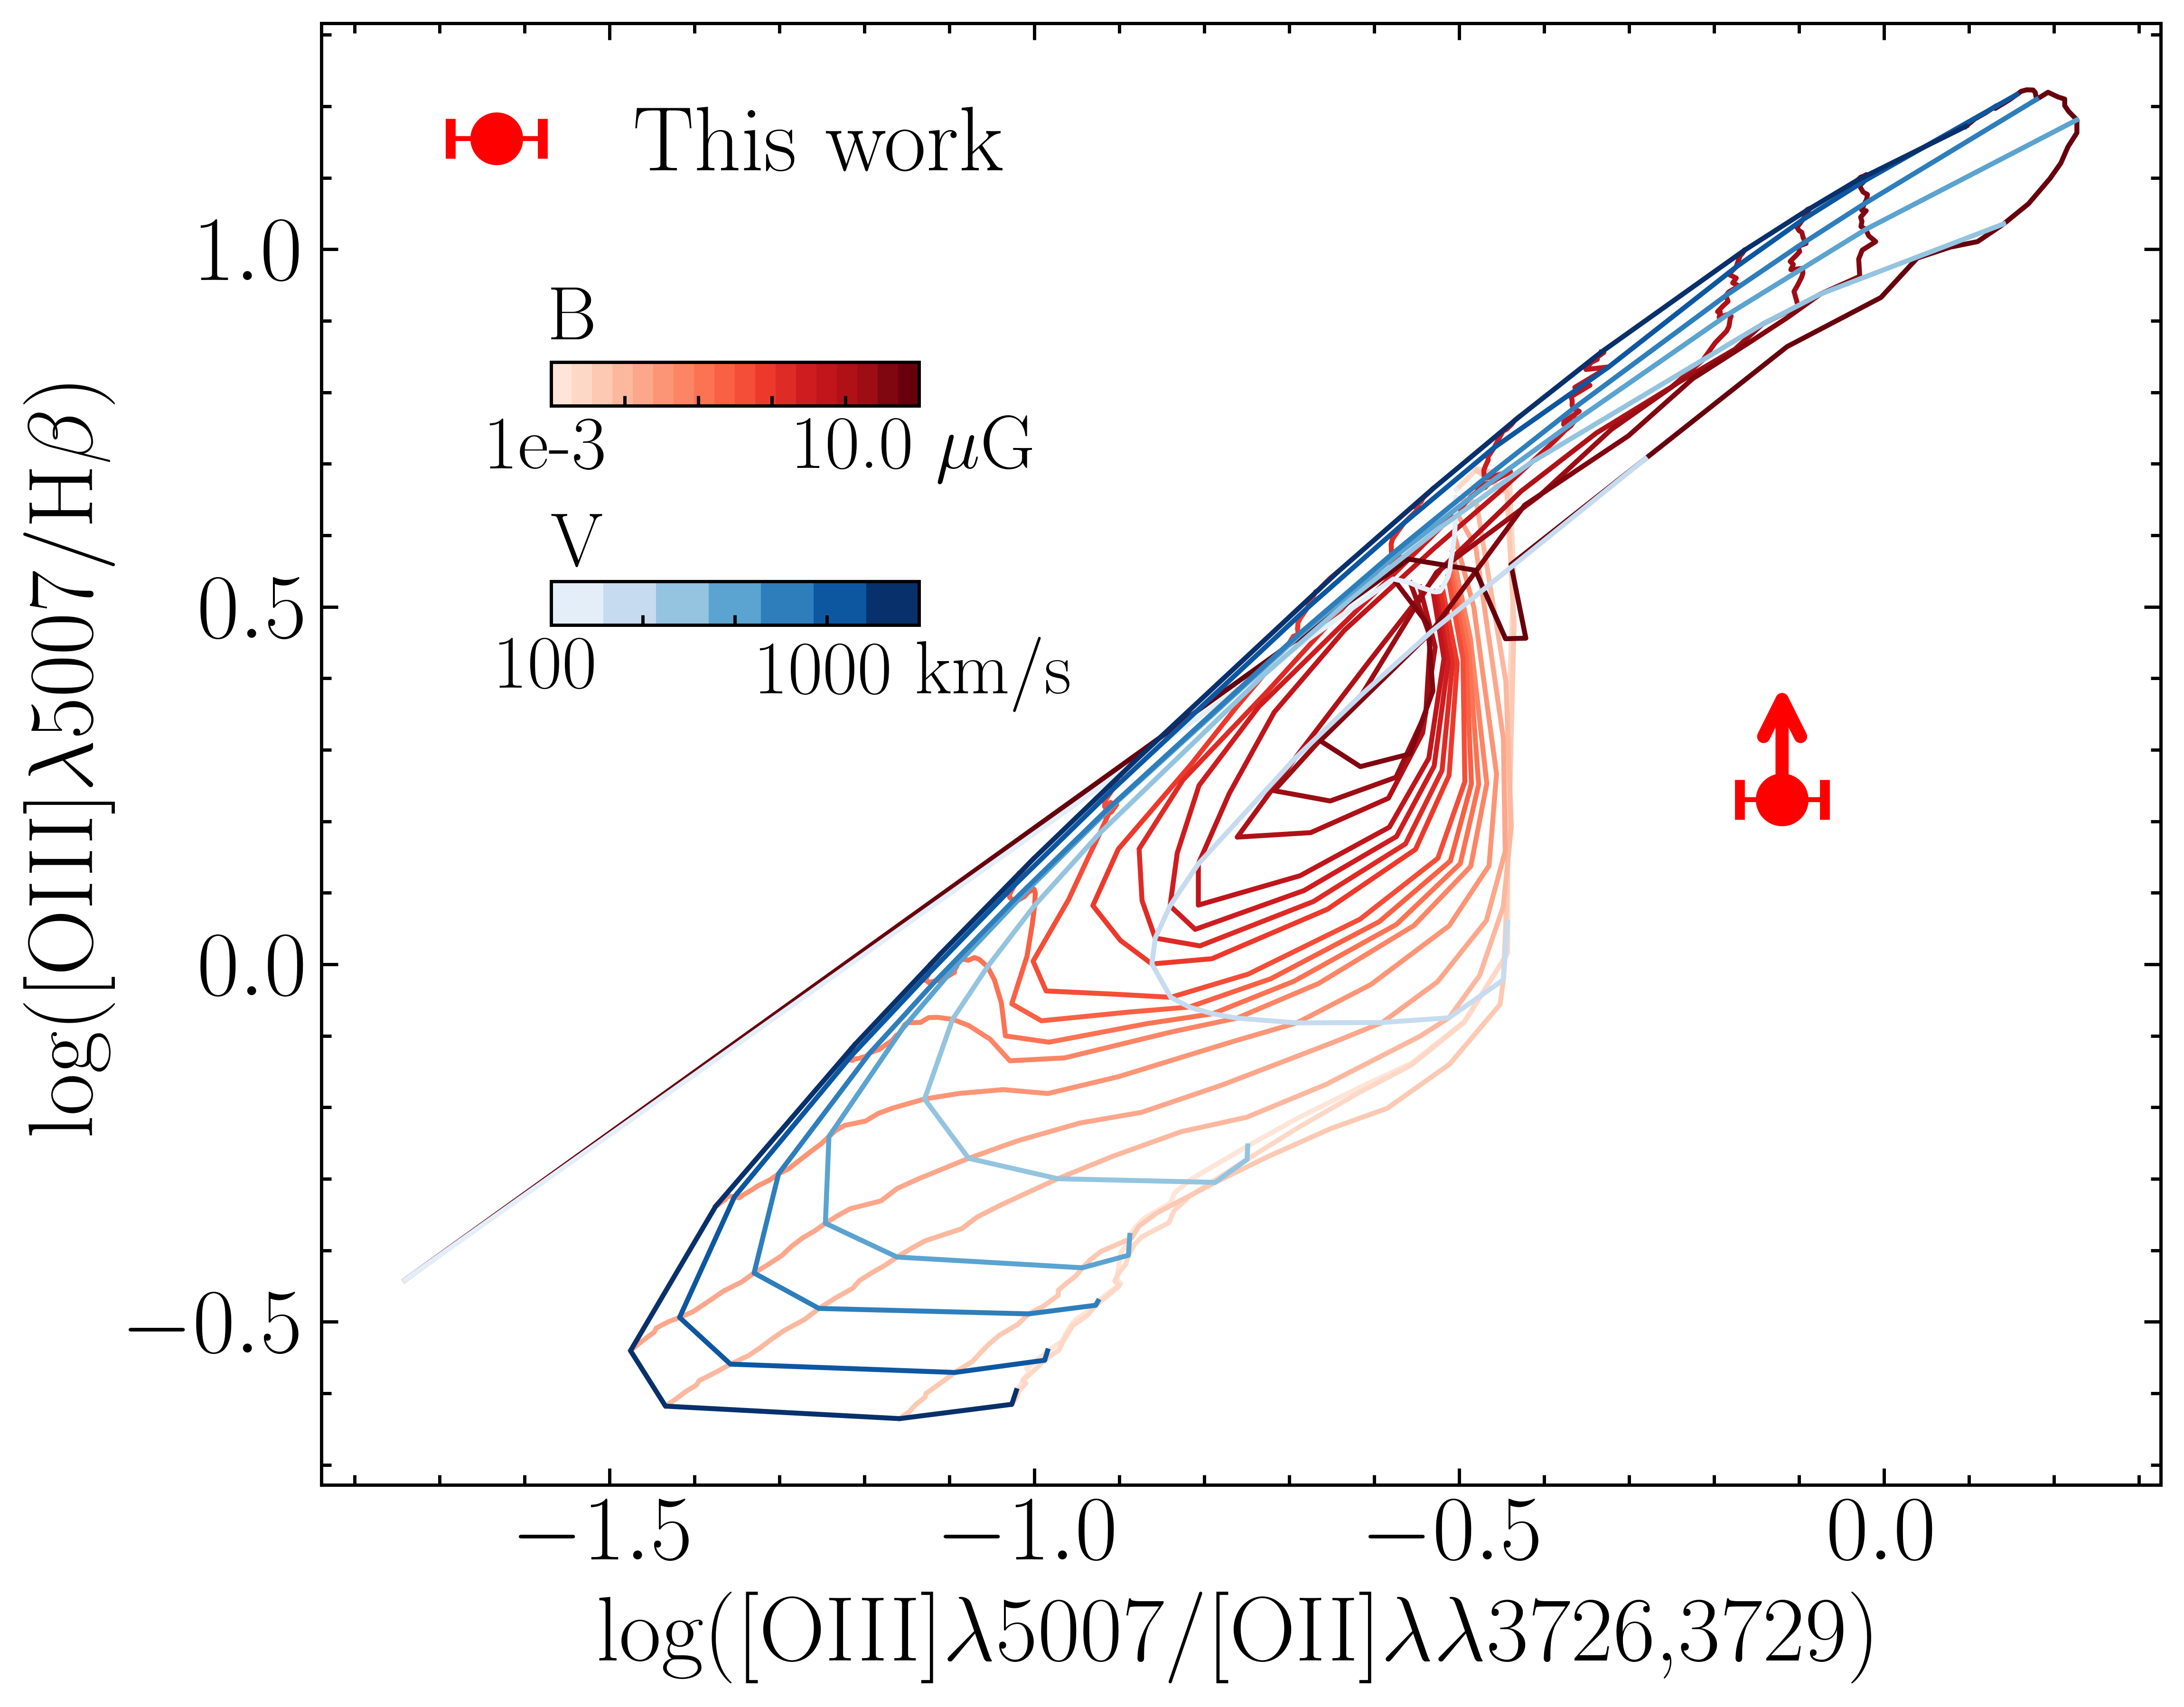

In [12]:
V_colorlist = plot_O32_O3Hb_grid('U')